#Logistic Regression

###Structure
This notebook divides into two parts:
* The first part uses a real world data set and is concerned with predicting extra-marital affairs. It uses machine learning libraries and reflects how you will most-likely go about solving real problems you encounter in your projects and beyond.
* The second uses toy data and while it uses numerical optimisation libraries, uses no black-box machine learning algorithms and is designed to get you to think about how logistic regression actually works.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import math
from scipy.optimize import minimize
%matplotlib inline 

/opt/anaconda/envs/Python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/anaconda/envs/Python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#Part I: Logistic Regression in Practice

##Affairs data:
This data is available at http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html but also contained in the statsmodels package

In [2]:
df = sm.datasets.fair.load_pandas().data
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


###What are we looking at?
(from the statsmodels webpage):

Number of variables: 9

Variable name definitions:

    rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                    4 = good, 5 = very good
    age             : Age
    yrs_married     : No. years married. Interval approximations. See
                    original paper for detailed explanation.
    children        : No. children
    religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                    4 = strongly
    educ            : Level of education, 9 = grade school, 12 = high
                    school, 14 = some college, 16 = college graduate,
                    17 = some graduate school, 20 = advanced degree
    occupation      : 1 = student, 2 = farming, agriculture; semi-skilled,
                    or unskilled worker; 3 = white-collar; 4 = teacher
                    counselor social worker, nurse; artist, writers;
                    technician, skilled worker, 5 = managerial,
                    administrative, business, 6 = professional with
                    advanced degree
    occupation_husb : Husband's occupation. Same as occupation.
    affairs         : measure of time spent in extramarital affairs

Note that in the above table, affairs is expressed as a float, a continuous number. Instead, we would like to ask the question, "has somebody had an affair or not", and then build a binary predictive classifier. So let us change the affairs column, so that every non-zero number is mapped to unity, which then denotes "this person has had an affair" (equivalent to this person has been unfaithful at least once).

In [3]:
df['affair']=df['affairs'].map(lambda x: 1 if x>0 else 0)
print df.head()

   rate_marriage   age  yrs_married  children  religious  educ  occupation  \
0            3.0  32.0          9.0       3.0        3.0  17.0         2.0   
1            3.0  27.0         13.0       3.0        1.0  14.0         3.0   
2            4.0  22.0          2.5       0.0        1.0  16.0         3.0   
3            4.0  37.0         16.5       4.0        3.0  16.0         5.0   
4            5.0  27.0          9.0       1.0        1.0  14.0         3.0   

   occupation_husb   affairs  affair  
0              5.0  0.111111       1  
1              4.0  3.230769       1  
2              5.0  1.400000       1  
3              5.0  0.727273       1  
4              4.0  4.666666       1  


Let's get a feel for how many people have had affairs:


In [4]:
print "Affairs=",sum(df['affair']==1),"No Affair=",sum(df['affair']==0)

Affairs= 2053 No Affair= 4313


If we group by the affair column and take means of the continuous quantities, we can quickly get a feel for which quantities might be affecting the likelihood of an affair. Clearly for the categorical quantities (occupation and occupation of the husband), these make no sense

In [5]:
df.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


It is similarly interesting to group by years married

In [6]:
df.groupby('yrs_married').mean()

,rate_marriage,age,children,religious,educ,occupation,occupation_husb,affairs,affair
yrs_married,,,,,,,,,
0.5,4.524324,22.156757,0.048649,2.454054,14.237838,3.302703,3.502703,0.546486,0.043243
2.5,4.239921,23.640364,0.297198,2.312684,14.384956,3.383481,3.614061,0.984877,0.215831
6.0,4.066608,26.439089,1.036810,2.347064,14.454864,3.469763,3.881683,0.741184,0.339176
9.0,3.985050,28.985050,1.649502,2.368771,14.367110,3.393688,4.061462,0.737495,0.421927
13.0,4.038983,32.610169,1.916102,2.457627,14.218644,3.474576,4.100000,0.508149,0.411864
16.5,3.952323,35.135697,2.814181,2.601467,13.710269,3.415648,4.014670,0.484304,0.451100
23.0,3.956843,41.013564,3.281751,2.652281,13.794081,3.511714,4.051788,0.369099,0.425401


#Some Data Visualisations

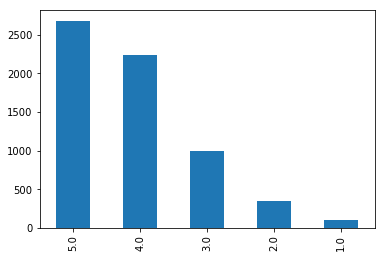

In [7]:
rating=df.rate_marriage.value_counts()
rating.plot(kind='bar')
plt.show()

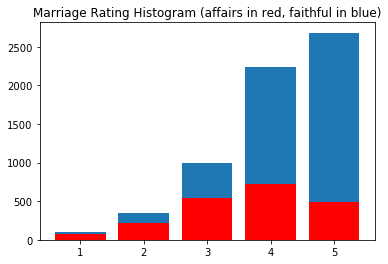

In [8]:
marriage_ratings=np.unique(df['rate_marriage'])
affairs_rate=[len(df[(df['affair']==1)&(df['rate_marriage']==i)]) for i in marriage_ratings]
no_affairs_rate=[len(df[(df['affair']==0)&(df['rate_marriage']==i)]) for i in marriage_ratings]

plt.figure()
plt.title("Marriage Rating Histogram (affairs in red, faithful in blue)")
plt.bar(np.unique(df['rate_marriage']),affairs_rate,align='center',color='r')
plt.bar(np.unique(df['rate_marriage']),no_affairs_rate,align='center',bottom=affairs_rate)

plt.show()

##Dealing with Categorical Data
Some of the features, such as the age of a woman are more or less continuous (technically they are integer so not continuous because we don't have their 'exact' age but let's gloss over that). 

Other features such as a woman or her partner's occupation are categorical. If somebody has occupation type 2, that does not make their job "more similar" to somebody of job type 1 than job type 5. For that reason, this is generally dealt with by a feature engineering technique called making "dummy variables". The general idea is to get rid of a column which contains such categorical entries, and make new columns for each possible value. Because there are 6 possible occupations, this would result in making six columns labelled "Job 1" , "Job 2" etc. If somebody is in occupation 2, they get an entry of 1 in the "Job 2" column and 0 elsewhere.

The Patsy library and its dmatrices method is used for this. Other possible options are Pandas get_dummies method.

The synatx of patsy's dmatrices function is to denote features with a categorical with a C before them. Features which are continuous are just denoted by their name. The ~ between affair and the rest of the features denotes that affair is the target variable/label and everything subsequent are features.

In [9]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + \
                   C(educ) + C(occupation) + C(occupation_husb)',
                  df, return_type="dataframe")
print X.columns

Index([u'Intercept', u'C(educ)[T.12.0]', u'C(educ)[T.14.0]',
       u'C(educ)[T.16.0]', u'C(educ)[T.17.0]', u'C(educ)[T.20.0]',
       u'C(occupation)[T.2.0]', u'C(occupation)[T.3.0]',
       u'C(occupation)[T.4.0]', u'C(occupation)[T.5.0]',
       u'C(occupation)[T.6.0]', u'C(occupation_husb)[T.2.0]',
       u'C(occupation_husb)[T.3.0]', u'C(occupation_husb)[T.4.0]',
       u'C(occupation_husb)[T.5.0]', u'C(occupation_husb)[T.6.0]',
       u'rate_marriage', u'age', u'yrs_married', u'children', u'religious'],
      dtype='object')


We are going to use Sci-kit learn's logistic regression library. Sci-kit learn's fit functions tend to take an (n_data_points x n_feat) array of feature readings and a (n_data_points x 1) array containing labels. Consequently, we convert X and y which are pandas object data types into numpy arrays.

In [10]:
X=np.array(X)
y=np.array(y)

print y

[[ 1.]
 [ 1.]
 [ 1.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


Note there's a little problem here when we print y. It has been converted as a list of lists of length 1. It turns out that sci-kit learn is smart enough to deal with this, but it complains. In such cases, it's good practice to use numpy's ravel function. Ravel takes an array and "flattens" it. Example np.ravel([[1,2],[3,4,5]])=[1,2,3,4,5]

In this case, we are really only looking for np.ravel([[1],[1]])=[1,1]

In [11]:
y=np.ravel(y)

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [12]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7266729500471254

The model is able to correctly predict if somebody is having an affair 72.7% of the time. But how many people are actually having an affair? If 10% of all respondents are having an affair, then simply predicting that nobody is doing so will result in 90% accuracy. This is a case of what is known as the "accuracy paradox".

In [13]:
y.mean()

0.32249450204209867

You should have seen that 32.2% of respondents are having an affair, meaning that 67.8% is the baseline accuracy we need to beat for our model to have any predictive power. Indeed, 72.7% is substantially above this baseline and thus better than having no model at all. 

## Using a training and a test set.
Currently, we trained a model using all of the data available, then we (using sci-kit learn's model.score function) looped back over the data and checked in how many cases the model correctly predicted whether that person was having an affair or not. This is somewhat prone to over fitting, as the data we are querying is already contained within the data the model was trained against. In a sense, the model has already seen these cases. A better test of model validity is to split the data into a training and a test set. Sci-kit learn has a nice function called train_test_split which splits data into test and training sets of user defined sizes, and does so selecting randomly from the global set (without replacement), see http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html.

The syntax is as follows: test_train_split(sample_to_split, test_size= , (optional kwargs))
The test size is expressed as a fraction, so test_size=0.1 means the data will be split such that 10% of the total data set is in the test set and 90% in the training set.

test_train_split returns train_set,test_set in that order so standard syntax would be:

train_set,test_set=test_train_split(full_data_set,test_size=0.1) 

in order to get a 90/10 split.

test_train_split has a further nice quality, that it can split more than 1 array simultaneously and likewise do so in a  corresponding manner. This is most frequently useful when your features and labels are stored in different arrays, but of course you want to make sure that sets of corresponding feature and label data are pulled from the global data set. The syntax for splitting the features and labels into a training and test sets in a 70/30 split is shown below

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = LogisticRegression(penalty='l2',C=100)
model.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Now for the test data, we predict its class (affair/no affair) for each set of feature values

In [15]:
predicted = model.predict(X_test)
print predicted

[ 1.  0.  0. ...,  0.  0.  0.]


Furthermore, sci-kit learn can tell us how sure it is of its predictions. Clearly for absolute predictions, if it thinks there is a 51% change of the woman in question having an affair, it still predicts affair. The predict_proba method on the other hand gives us this information in the format [probability of no affair, probability of affair] for every woman in the test set.

In [16]:
probs = model.predict_proba(X_test)
print probs

[[ 0.316775    0.683225  ]
 [ 0.92623284  0.07376716]
 [ 0.70497755  0.29502245]
 ..., 
 [ 0.61179583  0.38820417]
 [ 0.81995723  0.18004277]
 [ 0.72224675  0.27775325]]


##Accuracy
metrics.accuracy_score compares the test set's labels and the predicted values and divides the number which agree by the the total size of the test set

In [17]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)

0.728272251309


The accuracy is around 73%, which is the same as we experienced when training and predicting on the same data.
##Using Cross validatation
Cross validation involves performing the process of splitting into a test and training set multiple times to see whether the process itself is highly unstable. 

In [18]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
#add the kwarg n_jobs=-1 to run multiple cross-validations in parallel across all the cores available
#to you on your machine. Allegedly this doesn't always work in windows but should be fine on unix systems
print scores
print scores.mean()

[ 0.72413793  0.69435737  0.73824451  0.71226415  0.70597484  0.73427673
  0.71383648  0.70597484  0.75314465  0.75786164]
0.724007314525


## Predicting the Probability of an Affair

**Exercise** 

Just for fun, let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher (occupation=4, see very top of notebook for a reminder) who graduated college (education=16), has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair (=3), and her husband is a farmer (occupation #2).

columns:
u'Intercept'
u'C(educ)[T.12.0]'
u'C(educ)[T.14.0]'
u'C(educ)[T.16.0]'
u'C(educ)[T.17.0]'
u'C(educ)[T.20.0]',
u'C(occupation)[T.2.0]'
u'C(occupation)[T.3.0]',
u'C(occupation)[T.4.0]'
u'C(occupation)[T.5.0]',
u'C(occupation)[T.6.0]'
u'C(occupation_husb)[T.2.0]'
u'C(occupation_husb)[T.3.0]'
u'C(occupation_husb)[T.4.0]'
u'C(occupation_husb)[T.5.0]'
u'C(occupation_husb)[T.6.0]'
u'rate_marriage'
u'age'
u'yrs_married'
u'children'
u'religious'

In [19]:
sample = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4])

p = model.predict_proba(sample)
print p

[[ 0.91612281  0.08387719]]


/opt/anaconda/envs/Python2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


So it looks like this woman is likely to be faithful. Do you have any married friends you dare put to the test ;) ?

#Part II: Logistic Regression Fundamentals

##The Logit Function
The logit function is given by $logit(x)=\frac{1}{1+e^{-x}}$. To build up intuition, let's plot logit(x), logit(2x) and logit(x-a) by running the next cell.

###High number instabilities
Python is prone to complain if you ask it to calculate $e^{50}$ for example. Despite the fact that $\frac{1}{1+e^{-50}}$ is very well-defined and essentially equal to unity, calculating logit(50) in this way is prone to math domain errors. For this reason, we have added a truncation for $|x|>30$. For $x<-30$ we return logit(-30) and similarly for $x>30$.

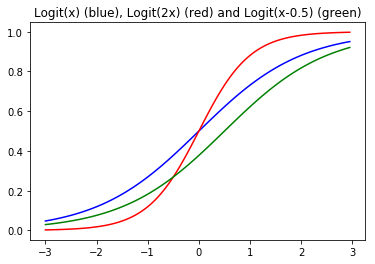

In [20]:
def logit(x):
    #truncate the domain of the function to avoid high number instabilities and math domain errors
    if x>30.:
        return logit(30)
    elif x<-30.:
        return logit(-30)
    return(1./(1+math.exp(-1.*x)))

sample_points=[float(i-60)/20. for i in range(120)]


plt.figure()
plt.title("Logit(x) (blue), Logit(2x) (red) and Logit(x-0.5) (green)")
logit_points=[logit(sample_points[i]) for i in range(len(sample_points))]
plt.plot(sample_points,logit_points,c='b')
logit_points=[logit(2*sample_points[i]) for i in range(len(sample_points))]
plt.plot(sample_points,logit_points,c='r')
logit_points=[logit((sample_points[i]-0.5)) for i in range(len(sample_points))]
plt.plot(sample_points,logit_points,c='g')
plt.show()

As should be evident from the above plot, when we fit a logit function (in one dimension), there are two things we can tune, the steepness and the offset. By offset, it is meant the point at which the logit function=0.5. This is the point of inflection and the decision boundary. The steepness governs how quickly a prediction goes from a "very uncertain" value of 0.5 to values of high certainty. 

Next let's read in some data and then plot it:

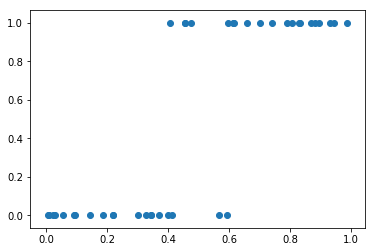

In [21]:
data=np.load("1d_data.npy")
features=[i[0] for i in data]
classifier=[i[1] for i in data]

plt.scatter(features,classifier)
plt.show()

##Separability of the data
It should be evident from the above plot, that in general, points with lower values of x tend to be in the class labelled as "0" and points with higher values of x are likely to be in class 1. Nonetheless, there is a transition region, roughly from x=0.4-0.6 in which the x-value does not tell us the class definitively. Intuitively, one would expect the "best" logit function to be one which is centred roughly at x=0.5 and which is predicting high certainty values for $x<0.4$ and $x>0.6$.


##Maximum Likelihood/Logloss
But how do we calculate this exactly? What is it we are trying to optimise? Given we have to make multiple predictions (one for each data point), the best prediction is one which has assigned the highest probability to the actual outcome. This is a manifestation of the so-called maximum likelihood principle. We are trying to maximise $\Pi_{i}p_{i}$ in which $p_{i}$ is the probability we predicted of the actual classification of each individual training instance. Because however, this might be a product over a potentially very large data set, and each of these probabilities is less than unity, $\Pi_{i}p_{i}$ will more often than not be a very small number (there will be a so-called likelihood attached to every possible outcome, which for a data set with N points and two possible classes means $2^{N}$ different scores which must sum to unity). In order to not run into small number numerical innaccuracy problems, we take the log of the likelihood score which turns the product into a sum $\Sigma _{i}\log(p_{i})$. The log function is monotonic so we are still looking to maximise this score.

For a binary classifier in which we label the classifiers as 1 and 0, if $p_{i}$ represents the probability that data point i belongs to class 1, we can express this as $\Sigma _{i} \left(p_{i}\log (p_{i}) + (1-p_{i})\log(1-p_{i})\right)$

$p_{i}=logit(x_{i};\theta)$ in which $x_{i}$ are the features and $\theta$ is the set of parameters that must be optimised. The rest of this notebook will be to do with examining various sets of toy training data, deciding what parameters it makes sense to include by way of visualising the data and then optimising them to maximise our log-likelihood (or logloss) score.

##Parameter optimisation in 1d
For the first data set, we need to optimise two parameters, the offset and the steepness. This will determine where the decision boundary is, as well as how far from the decision boundary one must be in order to get predictions with a high certainty. The function below calculates the log likelihood score for a set of data with 1 feature using a logit function with these two properties as a predictor (for a binary classifier)

In [22]:
def one_d_logloss(data,label,steepness,offset):
    log_sum=0
    if(len(label)!=len(data)):
        print "Features and Labels have different lengths and cannot correspond"
        return
    
    for i in range(len(data)):
        if label[i]==1:
            #taking the log base 10 but other logs are valid
            log_sum+=math.log(logit(steepness*(data[i]-offset)),10)
        else:
            log_sum+=math.log((1-logit(steepness*(data[i]-offset))),10)
    return(log_sum)

#in order to use scipy's minimise method, we'll need a wrapper function. We return -1* logloss because we are going to use
#scipy's minimise function but we want to maximise logloss

def one_d_wrapper(parameters):
    return -1*one_d_logloss(features,classifier,parameters[0],parameters[1])



Now we are ready to run scipy's minimise. Note that because we have truncated the logit function's domain at $|x|\leq 30$, this can lead to scipy complaining about loss of accuracy, but we know that this will be minimal.

In [23]:
#the only compulsory argument for scipy's minimize function is an initial starting guess for the parameters. More details
#for optional arguments to bound the search or use a different method can be found here: http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.minimize.html
minimisation_result=minimize(one_d_wrapper,[0,0])

minimisation_result

      fun: 3.9497211221115496
 hess_inv: array([[  5.48676258e+01,  -4.74487948e-02],
       [ -4.74487948e-02,   4.09670927e-03]])
      jac: array([ -1.19209290e-07,  -2.71201134e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 13
     njev: 18
   status: 0
  success: True
        x: array([ 14.26399955,   0.47417012])

The output might vary slightly when you run it on your machine, but the parameter values should give you a classifier which looks roughly like
$\frac{1}{1+e^{-14.264\left(x-0.474\right)}}$

Let's plot the exact result and overlay it on the data

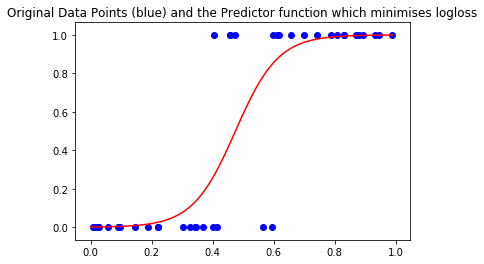

In [24]:
steepness=minimisation_result['x'][0]
offset=minimisation_result['x'][1]

x_axis=[float(i)/100. for i in range(100)]
predictor=[logit(steepness*(x_axis[i]-offset)) for i in range(len(x_axis))]
plt.figure()
plt.title("Original Data Points (blue) and the Predictor function which minimises logloss")
plt.scatter(features,classifier,c='b')
plt.plot(x_axis,predictor,c='r')
plt.show()

The remainder of this notebook will involve performing this process for different data sets.

##2d Data
Read the followng data in and visualise it

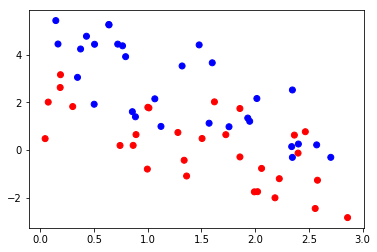

In [25]:
data=np.load("2d_data_linear.npy")
x=[i[0] for i in data]
y=[i[1] for i in data]
classifier=[i[2] for i in data]

plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()

Looking at the above plot, we see that it looks as if, but for noise, there is a linear decision boundary which separates the red and the blue classes (labelled as 1 and 0 respectively). How do we fit a logit function to this? Firstly, this is now a logit function in two variables. Let us assume that our decision boundary is given by the line $y=ax+b$ with a and b to be determined. 

For a standard, one dimensional, logit(x) function, logit(0)=0.5, i.e. denotes the decision boundary. As $|x|$ increases, we become ever more certain in our predictions. The equivalent here, is that we are looking at $logit(y-ax-b)$. If $y > ax+b$, then we are "above" the decision boundary and would expect to be within the blue region (especially if $y\gg ax+b$) and similarly if $y \ll ax+b$, we would expect to be within the red region. Furthermore, in order to determine how quickly we want our predictions to become certain as we get further from the decision boundary, we must add a steepness coefficient. Thus the full logit function, including all of the parameters we need to tune, is given by:

$logit\left((\gamma(y-ax+b)\right)$

Thus we define our predictor function to take the form $\frac{1}{1+e^{-\gamma \left(y-ax-b\right)}}$ and set out to maximise logloss for our data set

In [26]:
def linear_logloss_2d(steepness,gradient,intercept,x_feature,y_feature,label):
    logloss=0
    if(len(x_feature)!=len(y_feature)):
        print "Features cannot describe same data, length mismatch"
        return
    if(len(x_feature)!=len(label)):
        print "Features cannot describe classifier, length mismatch"
        return
    for i in range(len(x_feature)):
        if label[i]==1:
            logloss+=math.log(logit(steepness*(y_feature[i]-gradient*x_feature[i]-intercept)),10)
        else:
            logloss+=math.log(1-logit(steepness*(y_feature[i]-gradient*x_feature[i]-intercept)),10)
    return(logloss)
def linear_logloss_2d_wrapper(parameters):
    return -1*linear_logloss_2d(parameters[0],parameters[1],parameters[2],x,y,classifier)

minimisation_result=minimize(linear_logloss_2d_wrapper,[0,0,0])

print "Decision Boundary Line: y=%fx+%f"%(minimisation_result['x'][1],minimisation_result['x'][2])

Decision Boundary Line: y=-1.248455x+3.058754


Firstly, let us examine the shape of the decision boundary. 

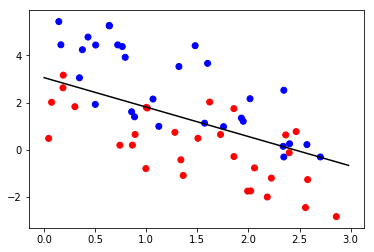

In [27]:
x_axis=[float(i)/50. for i in range(150)]
dec_boundary=[minimisation_result['x'][1]*x_axis[i] +minimisation_result['x'][2] for i in range(len(x_axis))]

plt.figure()
plt.plot(x_axis,dec_boundary,c='k')
plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()


The process of minimising logloss while imposing a linear decision boundary has implemented a sensible linear decision boundary which would have low classification error on the training data. Note that strictly speaking, to do this properly, it would be necessary to perform multiple train-test splits. The current data was generated using $y=-x+3$ as a decision boundary (while adding pseudo random noise) and thus this has actually resulted in over fitting.

Finally, let's  visualise the 3d logit function:

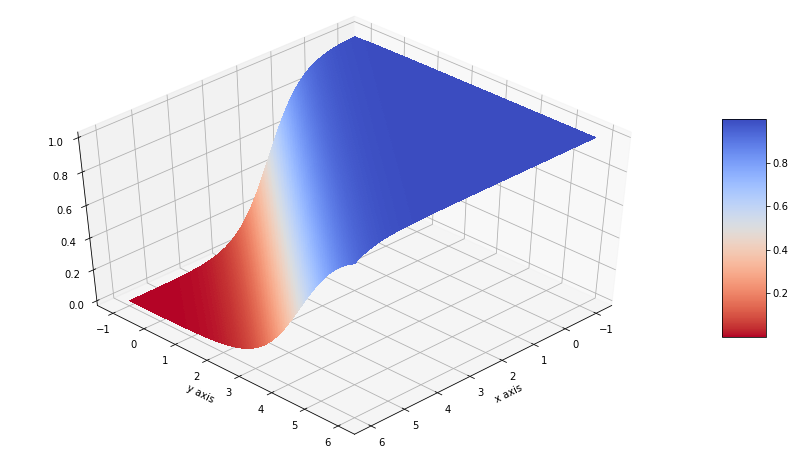

In [28]:
steepness=minimisation_result['x'][0]
gradient=minimisation_result['x'][1]
intercept=minimisation_result['x'][2]

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')

X = np.arange(-1, 6,0.02)
Y = np.arange(-1, 6,0.02)
X, Y = np.meshgrid(X, Y)

Z=[[1-logit(steepness*(Y[i][j]+X[i][j]*gradient +intercept )) for j in range(len(X[0]))] for i in range(len(Y[0])) ]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm_r,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.01, 1.01)

ax.set_xlabel("x axis")
ax.set_ylabel("y axis")


fig.colorbar(surf, shrink=0.5, aspect=5)

ax.azim = 45
ax.elev = 45

plt.show()


As Exercises, two more data sets are provided

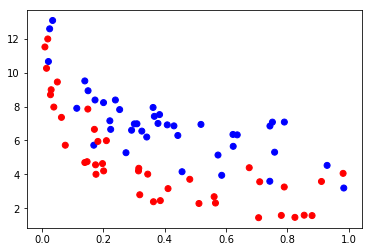

In [61]:
data=np.load("2d_data_reciprocal.npy")
x=[i[0] for i in data]
y=[i[1] for i in data]
classifier=[i[2] for i in data]

plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()


If you attempted to draw a decision boundary in the $(x,y)$ plane, what sort of function would it look like? (there's a hint in the data file name). Use this to define the parameters in your logit function which must then be optimised to maximise logloss.

Remember that if you think the decision boundary should look like $y=f(x;\theta)$, then the function you want to tune looks like $logit(\gamma \left(y-f(x;\theta)\right))$ with $\gamma$ and $\theta$ in need of tuning.

The Optimised Steepness is -1.2111336459
The decision boundary parameter values are
[-1.21113365  0.17996813 -4.50953114] 1
[-1.21113365  0.17996813 -4.50953114] 2


/opt/anaconda/envs/Python2/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in double_scalars


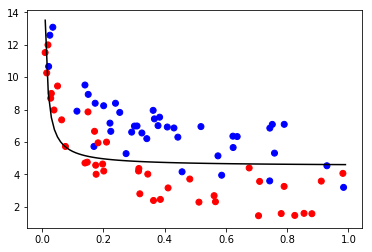

In [63]:
#add as many parameters as you see fit
def logloss_function_exercise(parameter_1,parameter_2,parameter_3,x_feature,y_feature,label): 
    logloss=0
    for i in range(len(x_feature)):
        if label[i]==1:
            logloss+=math.log(logit(parameter_1*(y_feature[i]- (parameter_2/x_feature[i]-parameter_3)  )),10)
        else:
            logloss+=math.log(1-logit(parameter_1*(y_feature[i]- (parameter_2/x_feature[i]-parameter_3)  )),10)
    return logloss

def logloss_function_exercise_wrapper(parameters):
    return -1*logloss_function_exercise(parameters[0],parameters[1],parameters[2],x,y,classifier)

#your initial guess vector will need the same number of components as the number of parameters you used

minimisation_result=minimize(logloss_function_exercise_wrapper,[0,1,0]) 


print "The Optimised Steepness is",minimisation_result['x'][0]
print "The decision boundary parameter values are"
for i in range(1,len(minimisation_result['x'])):
    print minimisation_result['x'],i

x_coordinates=[float(i)/100 for i in range(100)]
decision_boundary=[minimisation_result['x'][1]/x_axis[i]-minimisation_result['x'][2] for i in range(len(x_coordinates)) ]


plt.figure()
plt.plot(x_coordinates,decision_boundary,c='k')
plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()


And repeat the process with another data set

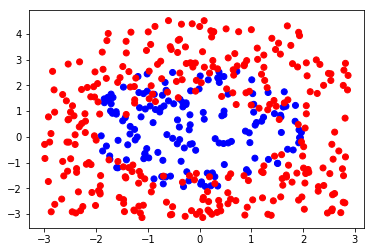

In [64]:
data=np.load("2d_data_elliptical.npy")
x=[i[0] for i in data]
y=[i[1] for i in data]
classifier=[i[2] for i in data]

plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()

In [66]:
def logloss_function_exercise(parameter_1,parameter_2,parameter_3,x_feature,y_feature,label): #add as many parameters as you see fit
    logloss=0
    for i in range(len(x_feature)):
        if label[i]==1:
            logloss+=math.log(logit(parameter_1*(y_feature[i]**2- parameter_2*x_feature[i]**2-parameter_3  )),10)
        else:
            logloss+=math.log(1-logit(parameter_1*(y_feature[i]**2- parameter_2*x_feature[i]**2-parameter_3  )),10)
    return logloss

def logloss_function_exercise_wrapper(parameters):
    return -1*logloss_function_exercise(parameters[0],parameters[1],parameters[2],x,y,classifier)

#you'll need to initialise the minimisation search for as many parameters as you include in your model
minimisation_result=minimize(logloss_function_exercise_wrapper,[1,1,0]) 

print "The Optimised Steepness is",minimisation_result['x'][0]
print "The decision boundary parameter values are"
for i in range(1,len(minimisation_result['x'])):
    print minimisation_result['x'],i

# x_coordinates=[float(i)/100 for i in range(100)]
# decision_boundary=[ -np.sqrt(minimisation_result['x'][1]+ minimisation_result['x'][2]*x_axis[i]**2) for i in range(len(x_coordinates)) ]
x_coordinates = np.linspace(-1.0, 1.0, 100)
y_coordinates = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x_coordinates,y_coordinates)
F = -minimisaztion_result['x'][1]*X**2 + Y**2 - minimisation_result['x'][2]


plt.figure()
#plt.plot(x_coordinates,decision_boundary,c='k')
plt.contour(X,Y,F,[0],c='k')
plt.scatter(x,y,c=classifier,cmap='bwr')
plt.show()

The Optimised Steepness is 0.768028233949
The decision boundary parameter values are
[ 0.76802823 -1.15414046  4.17881371] 1
[ 0.76802823 -1.15414046  4.17881371] 2


NameError: name 'minimisaztion_result' is not defined